## Pre-requisites

### Imports

In [58]:
import datetime
import glob
import json
import urllib
import os
from IPython.display import Image, display
from dlg import droputils
from dlg.dropmake.pg_generator import unroll, partition
from dlg.common.reproducibility.reproducibility import init_lgt_repro_data, init_lg_repro_data, \
    init_pgt_unroll_repro_data, init_pgt_partition_repro_data
from dlg.restutils import RestClient, RestClientException
from dlg.clients import CompositeManagerClient

### Constants

In [59]:
# N.B. - RASCIL_DATA MUST be set in the dlg engine's environment too.
RASCIL_DATA = os.path.expanduser("~/PycharmProjects/dlg_ska_jones/rascil_data/data")
DLG_HOME = os.path.expanduser("~/dlg/")

In [60]:
DLG_TRANSLATOR_HOST = "localhost"
DLG_MGR_HOST = "localhost"
DLG_TRANSLATOR_PORT = 8084
DLG_NODE_PORT = 8000
DLG_DIM_PORT = 8001
GRAPH_NAME = "AA05CaliTest1.graph"
GRAPH_DIR = "./"
GRAPH_PATH = f"{GRAPH_DIR}{GRAPH_NAME}"
TEST = False

## Opening the graph

In [61]:
with open(GRAPH_PATH, 'rb') as ifile:
    graph_data = ifile.read()

## Embedding Experiment Paramters

In [62]:
nsamples = 3
sample_time = 10.0
nchannels = 10
channel_bandwidth = 10e5
sky_model = 2
experiment_args = {
    'nsamples': nsamples,
    'sample_time': sample_time,
    'nchannels': nchannels,
    'channel_bandwidth': channel_bandwidth,
    'sky_model': sky_model,
}
file_prefix = f"{nsamples}-{sample_time}-{nchannels}-{channel_bandwidth}-{sky_model}"

In [50]:
graph_str = json.loads(graph_data)
for drop in graph_str['nodeDataArray']:
    for default_argument in drop['applicationArgs']:
        for arg_name, arg_val in experiment_args.items():
            if default_argument['name'] == arg_name:
                default_argument['value'] = arg_val

In [63]:
graph_data = json.dumps(graph_str)

## Submitting graph to remote end-point

In [3]:
def html_to_pgt_id(html_text):
    location = html_text.find("pgt_id")
    if location != -1:
        subline = line[location:]
        start_loc = subline.find('value=\"')
        end_loc = subline.find('\">')
        PGT_ID = subline[start_loc + 7:end_loc]
        return PGT_ID
    return None

In [4]:
c = RestClient("localhost", 8084, timeout=10)
# add 'correct' data to the form
form_data = {
    "algo": "metis",
    "lg_name": GRAPH_NAME,
    "json_data": graph_data,
    "num_islands": 0,
    "num_par": 1,
    "par_label": "Partition",
    "max_load_imb": 100,
    "max_cpu": 8,
}
PGT_ID = ""
# POST form to /gen_pgt
try:
    content = urllib.parse.urlencode(form_data)
    response = c._POST(
        "/gen_pgt", content, content_type="application/x-www-form-urlencoded"
    )
    response_content = response.readlines()
    for line in response_content:
        if html_to_pgt_id(line):
            break
except RestClientException as e:
    raise

print(PGT_ID)

RestClientException: Cannot connect to localhost:8084 after 10.00 [s]

## Translate Graph Locally

In [64]:
algo_params = {
    "min_goal": None,
    "ptype": None,
    "max_load_imb": 100,
    "max_cpu": 8,
    "time_greedy": None,
    "deadline": None,
    "topk": None,
    "swarm_size": None,
    "max_mem": None
}

In [65]:
num_islands = 0
num_partitions = 1
app = "dlg.apps.simple.SleepApp" if TEST else None

In [66]:
lgt = init_lg_repro_data(init_lgt_repro_data(json.loads(graph_data), "0"))
pgt = init_pgt_unroll_repro_data(unroll(lgt, app=app))
reprodata = pgt.pop()

### Partition the PGT

In [67]:
pgt = partition(
    pgt,
    algo="metis",
    num_partitions=num_partitions,
    num_islands=num_islands,
    partition_label="Partition",
    show_gojs=True,
    **algo_params,
)
pgt_spec = pgt.to_pg_spec(
    [],
    ret_str=False,
    num_islands=num_islands,
    tpl_nodes_len=num_partitions + num_islands,
)
pgt_spec.append(reprodata)
init_pgt_partition_repro_data(pgt_spec)
reprodata = pgt_spec.pop()
pgt.reprodata = reprodata

## Submit to mgr

In [84]:
mgr_client = CompositeManagerClient(
    host=DLG_MGR_HOST, port=DLG_DIM_PORT, timeout=30
)
# 1. get a list of nodes
node_list = mgr_client.nodes()
# 2. mapping PGTP to resources (node list)
pg_spec = pgt.to_pg_spec(node_list, ret_str=False)
reprodata = pgt.reprodata
dt = datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S.%f")
ssid = "{0}_{1}".format(
    PGT_ID.split(".graph")[0].split("_pgt")[0].split("/")[-1], dt
)
from dlg.manager.session import SessionStates
import time
mgr_client.create_session(ssid)
# print "session created"
completed_uids = droputils.get_roots(pg_spec)
pg_spec.append(reprodata)
mgr_client.append_graph(ssid, pg_spec)
# print "graph appended"
mgr_client.deploy_session(ssid, completed_uids=completed_uids)
while list(mgr_client.session_status(ssid).values())[0] != SessionStates.FINISHED:
    time.sleep(2)

## Reviewing results

(Assumes locally available manager)

/home/nikolas/dlg/workspace/3-10.0-10-1000000.0-2-*.png
['/home/nikolas/dlg/workspace/3-10.0-10-1000000.0-2-blockvisibilities.png', '/home/nikolas/dlg/workspace/3-10.0-10-1000000.0-2-solver_results.png', '/home/nikolas/dlg/workspace/3-10.0-10-1000000.0-2-solver_performance.png', '/home/nikolas/dlg/workspace/3-10.0-10-1000000.0-2-solver_error.png', '/home/nikolas/dlg/workspace/3-10.0-10-1000000.0-2-alg_error_comparison.png']


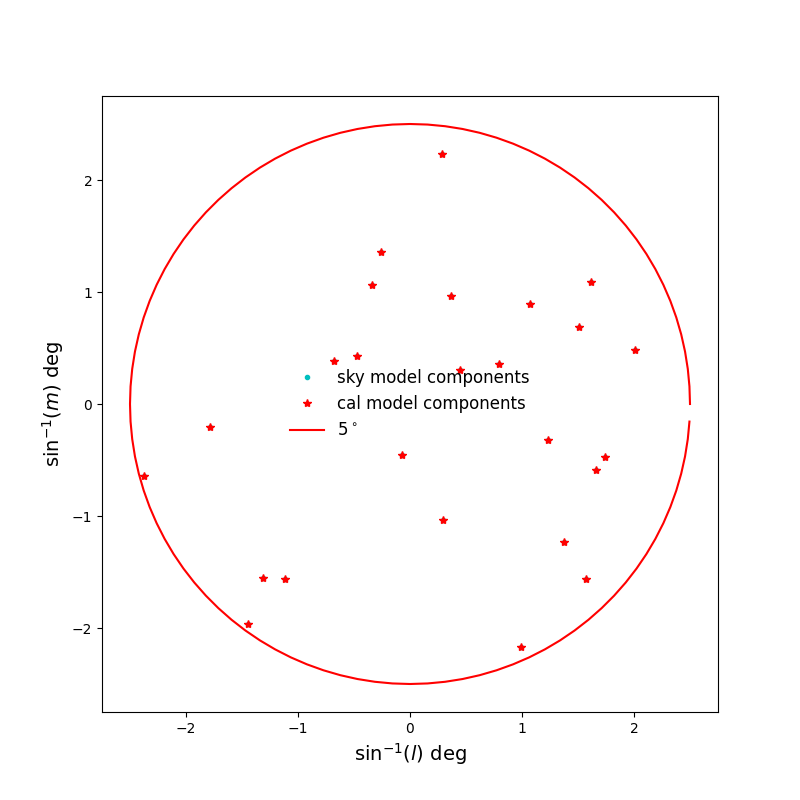

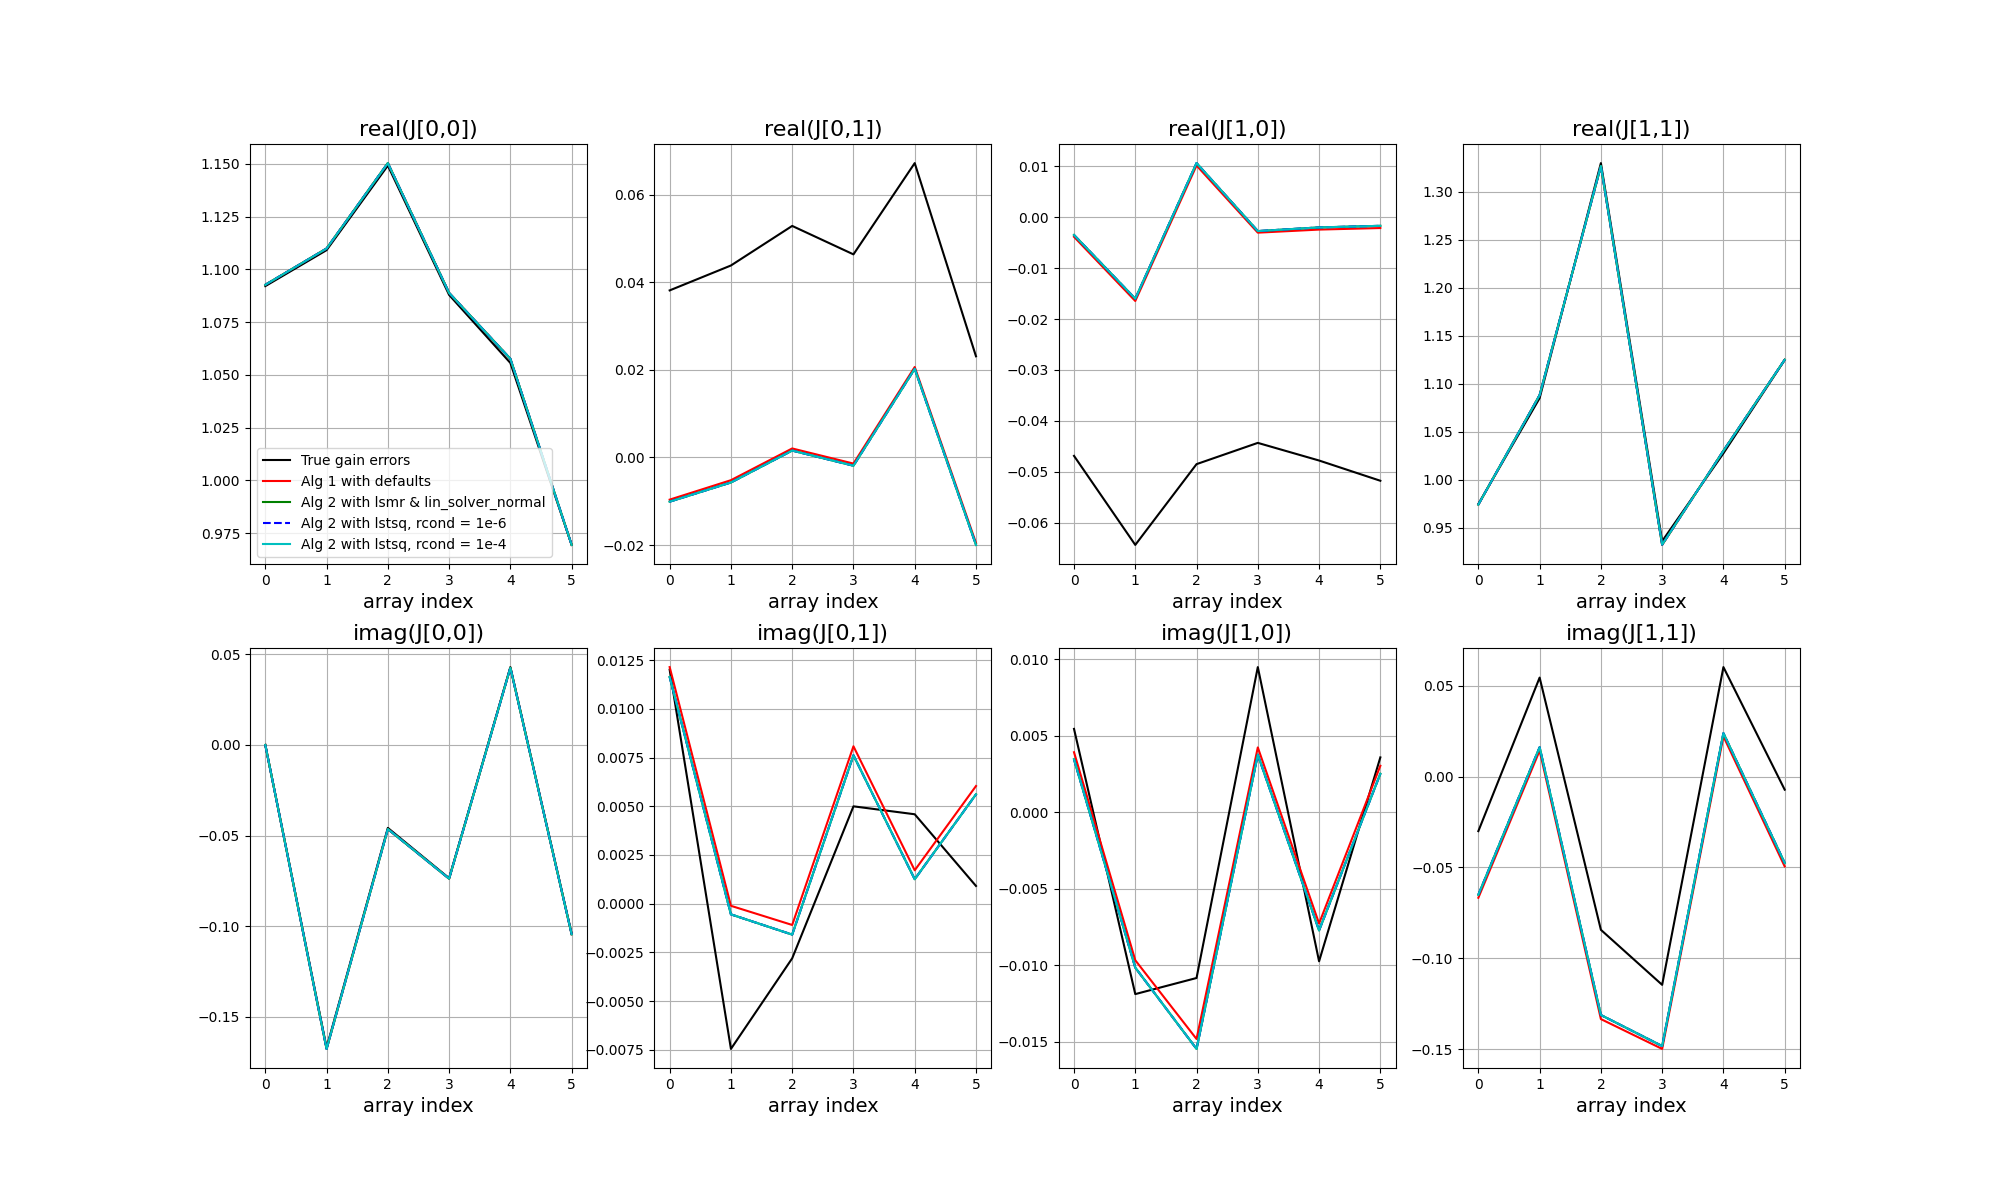

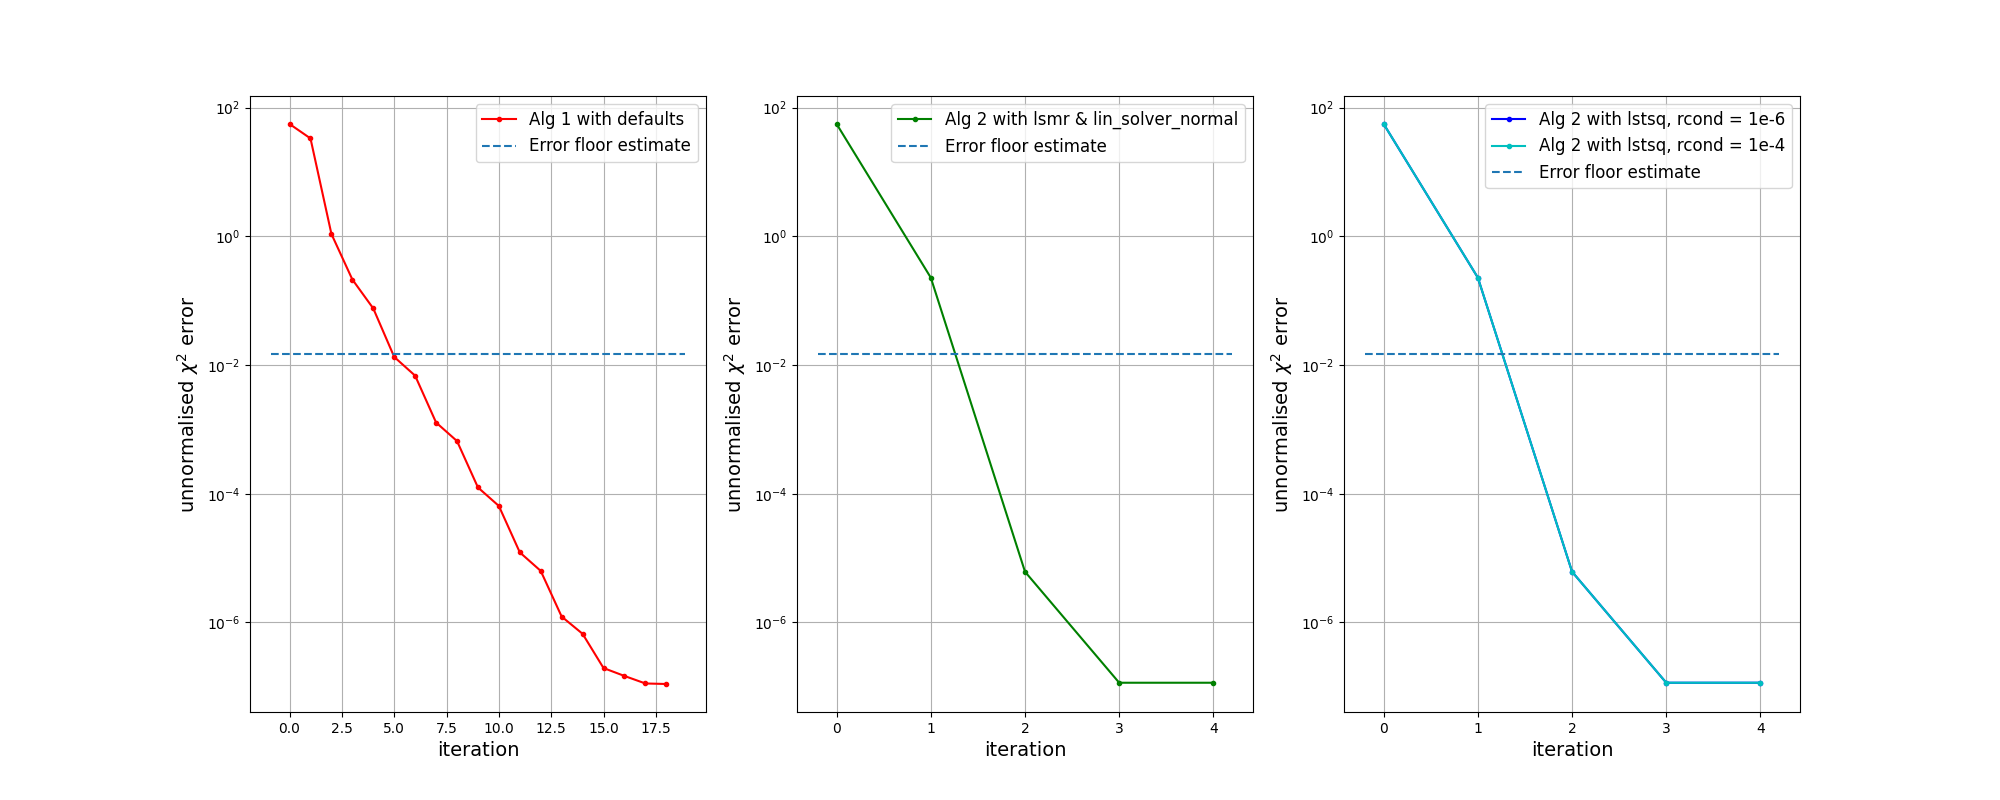

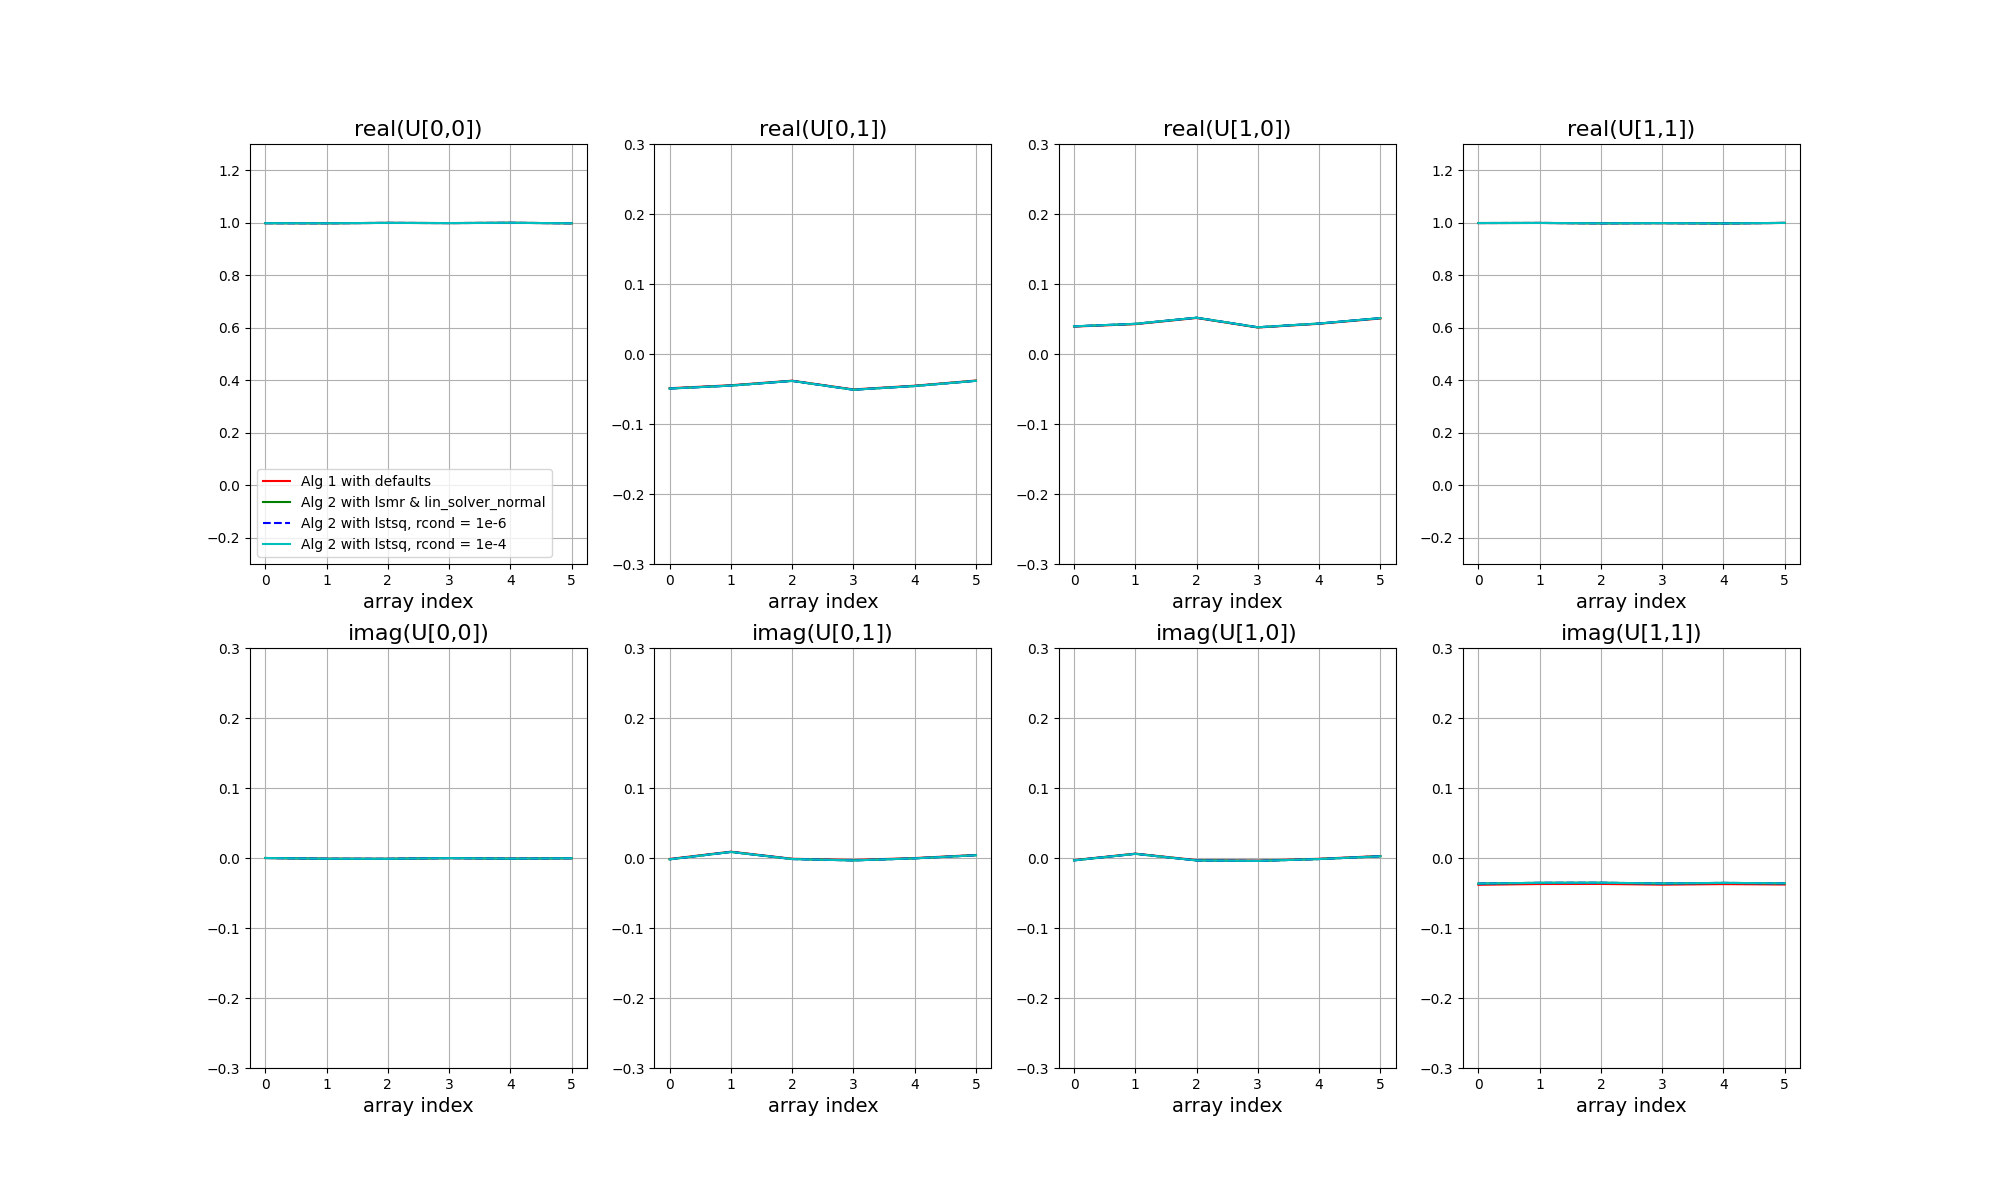

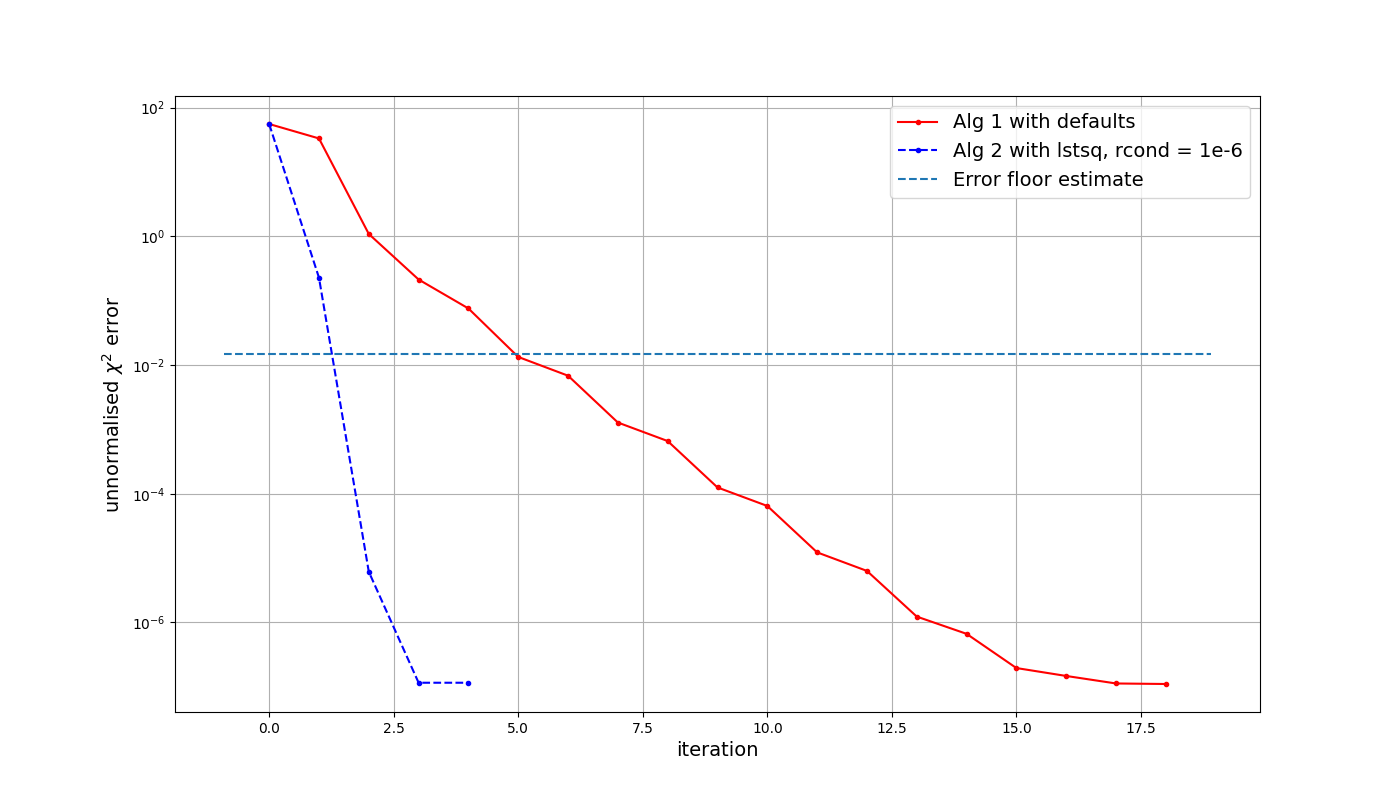

In [85]:
glob_query = fr"{DLG_HOME}workspace{os.sep}{file_prefix}-*.png"
files = glob.glob(glob_query)
print(glob_query)
print(files)
for filename in files:
    display(Image(filename=filename))